In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading signals from .mat file...
Loaded 5 PPG signals
Loaded 5 ABP signals
Loaded 5 ECG signals

Plotting sample 0...


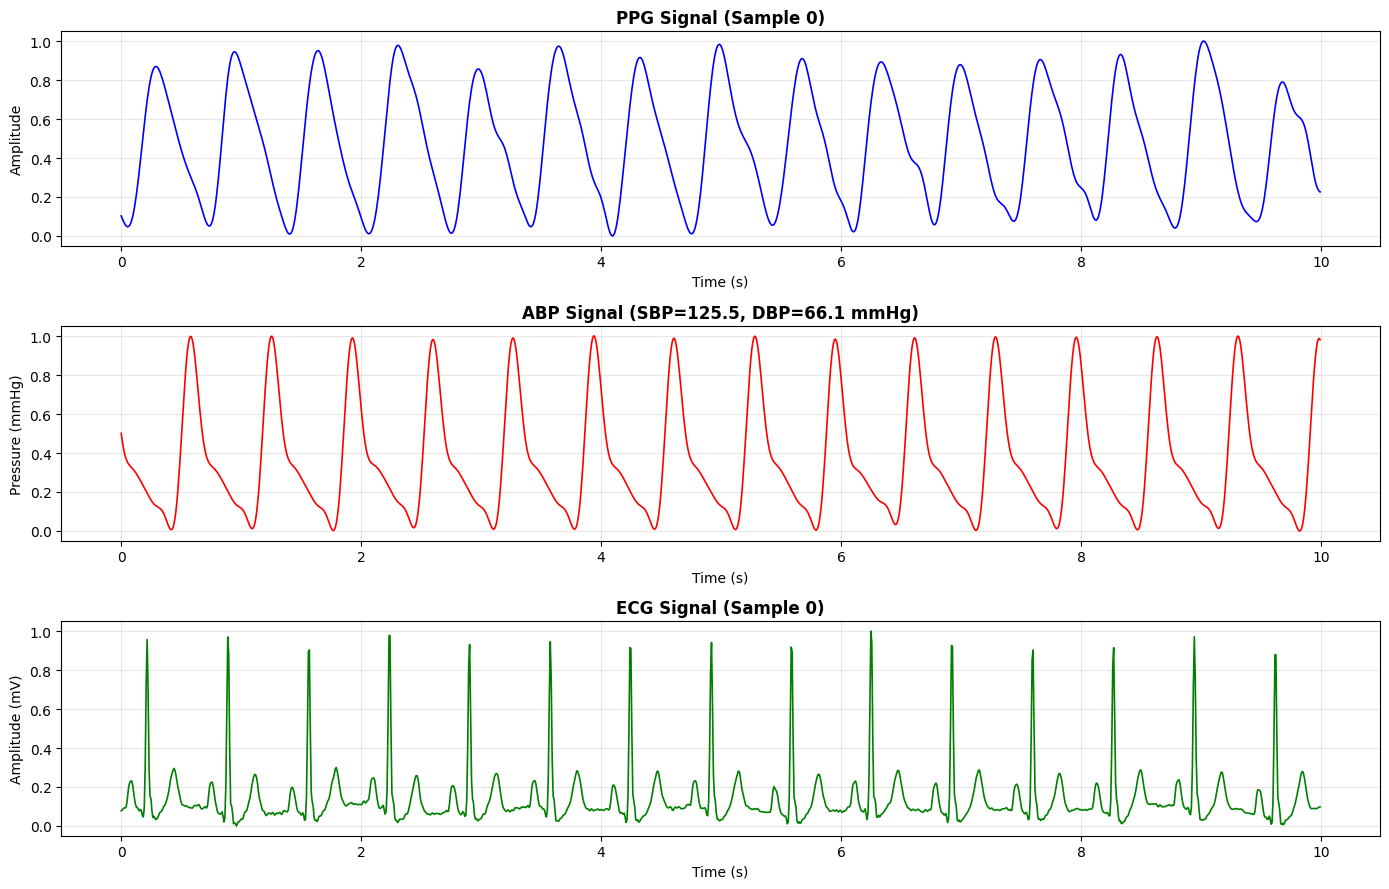


Plotting multiple PPG samples...


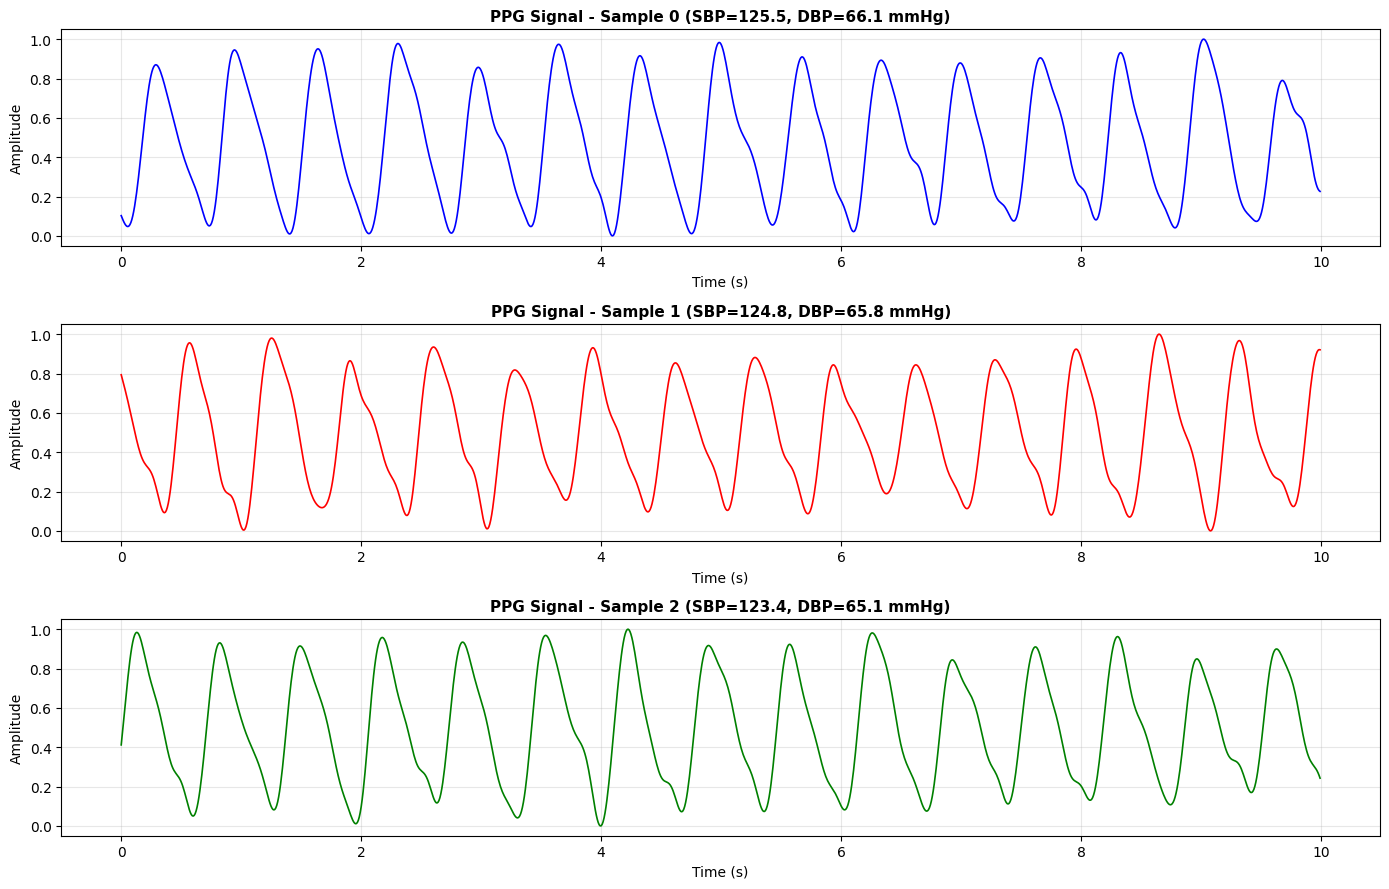


=== Signal Statistics ===
Sample 0: SBP=125.5 mmHg, DBP=66.1 mmHg, PPG length=1250 samples (10.00s)
Sample 1: SBP=124.8 mmHg, DBP=65.8 mmHg, PPG length=1250 samples (10.00s)
Sample 2: SBP=123.4 mmHg, DBP=65.1 mmHg, PPG length=1250 samples (10.00s)
Sample 3: SBP=123.4 mmHg, DBP=65.4 mmHg, PPG length=1250 samples (10.00s)
Sample 4: SBP=123.8 mmHg, DBP=65.4 mmHg, PPG length=1250 samples (10.00s)


In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# ========================
# 데이터 로딩 함수
# ========================
def load_signals_from_mat(mat_path, num_samples=5):
    """
    MATLAB .mat 파일에서 PPG, ABP, ECG 신호를 로드

    Parameters:
    - mat_path: .mat 파일 경로
    - num_samples: 로드할 샘플 개수

    Returns:
    - signals: dict {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}
    """
    signals = {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}

    with h5py.File(mat_path, 'r') as f:
        # 데이터 참조 가져오기
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        abp_refs = f['Subj_Wins']['ABP_F'][0] if 'ABP_F' in f['Subj_Wins'] else None
        ecg_refs = f['Subj_Wins']['ECG_F'][0] if 'ECG_F' in f['Subj_Wins'] else None
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        # 지정된 개수만큼 로드
        total = min(len(ppg_refs), num_samples)

        for i in range(total):
            # PPG 신호
            ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
            signals['ppg'].append(ppg)

            # ABP 신호 (있는 경우)
            if abp_refs is not None:
                abp = f[abp_refs[i]][()].squeeze().astype(np.float32)
                signals['abp'].append(abp)

            # ECG 신호 (있는 경우)
            if ecg_refs is not None:
                ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
                signals['ecg'].append(ecg)

            # 혈압 타겟
            sbp = float(f[sbp_refs[i]][()][0][0])
            dbp = float(f[dbp_refs[i]][()][0][0])
            signals['sbp'].append(sbp)
            signals['dbp'].append(dbp)

    return signals


# ========================
# 신호 시각화 함수
# ========================
def plot_signals(signals, sample_idx=0, fs=125):
    """
    PPG, ABP, ECG 신호를 시각화

    Parameters:
    - signals: load_signals_from_mat()의 반환값
    - sample_idx: 표시할 샘플 인덱스
    - fs: 샘플링 주파수 (Hz)
    """
    # 서브플롯 개수 계산
    num_plots = 1  # PPG는 항상 있음
    if signals['abp']: num_plots += 1
    if signals['ecg']: num_plots += 1

    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3*num_plots))
    if num_plots == 1:
        axes = [axes]

    plot_idx = 0

    # PPG 신호
    ppg = signals['ppg'][sample_idx]
    time_ppg = np.arange(len(ppg)) / fs
    axes[plot_idx].plot(time_ppg, ppg, 'b-', linewidth=1.2)
    axes[plot_idx].set_title(f'PPG Signal (Sample {sample_idx})', fontsize=12, fontweight='bold')
    axes[plot_idx].set_xlabel('Time (s)')
    axes[plot_idx].set_ylabel('Amplitude')
    axes[plot_idx].grid(True, alpha=0.3)
    plot_idx += 1

    # ABP 신호
    if signals['abp']:
        abp = signals['abp'][sample_idx]
        time_abp = np.arange(len(abp)) / fs
        axes[plot_idx].plot(time_abp, abp, 'r-', linewidth=1.2)
        sbp, dbp = signals['sbp'][sample_idx], signals['dbp'][sample_idx]
        axes[plot_idx].set_title(f'ABP Signal (SBP={sbp:.1f}, DBP={dbp:.1f} mmHg)',
                                fontsize=12, fontweight='bold')
        axes[plot_idx].set_xlabel('Time (s)')
        axes[plot_idx].set_ylabel('Pressure (mmHg)')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1

    # ECG 신호
    if signals['ecg']:
        ecg = signals['ecg'][sample_idx]
        time_ecg = np.arange(len(ecg)) / fs
        axes[plot_idx].plot(time_ecg, ecg, 'g-', linewidth=1.2)
        axes[plot_idx].set_title(f'ECG Signal (Sample {sample_idx})', fontsize=12, fontweight='bold')
        axes[plot_idx].set_xlabel('Time (s)')
        axes[plot_idx].set_ylabel('Amplitude (mV)')
        axes[plot_idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ========================
# 다중 샘플 비교 시각화
# ========================
def plot_multiple_samples(signals, num_samples=3, signal_type='ppg', fs=125):
    """
    여러 샘플의 신호를 한 번에 비교

    Parameters:
    - signals: 로드된 신호 데이터
    - num_samples: 표시할 샘플 개수
    - signal_type: 'ppg', 'abp', 'ecg' 중 선택
    - fs: 샘플링 주파수
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3*num_samples))
    if num_samples == 1:
        axes = [axes]

    signal_data = signals[signal_type]
    colors = ['blue', 'red', 'green']

    for i in range(min(num_samples, len(signal_data))):
        sig = signal_data[i]
        time = np.arange(len(sig)) / fs

        axes[i].plot(time, sig, color=colors[i % 3], linewidth=1.2)

        title = f'{signal_type.upper()} Signal - Sample {i}'
        if signal_type == 'ppg' and signals['sbp']:
            title += f' (SBP={signals["sbp"][i]:.1f}, DBP={signals["dbp"][i]:.1f} mmHg)'

        axes[i].set_title(title, fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ========================
# 사용 예제
# ========================
if __name__ == "__main__":
    # 파일 경로 설정
    mat_path = "/content/drive/MyDrive/Colab Notebooks/MIMIC_S/p044036.mat"  # 실제 파일 경로로 변경

    # 1. 데이터 로딩
    print("Loading signals from .mat file...")
    signals = load_signals_from_mat(mat_path, num_samples=5)

    print(f"Loaded {len(signals['ppg'])} PPG signals")
    print(f"Loaded {len(signals['abp'])} ABP signals")
    print(f"Loaded {len(signals['ecg'])} ECG signals")

    # 2. 단일 샘플 시각화 (모든 신호 타입)
    print("\nPlotting sample 0...")
    plot_signals(signals, sample_idx=0, fs=125)

    # 3. PPG 신호 여러 샘플 비교
    print("\nPlotting multiple PPG samples...")
    plot_multiple_samples(signals, num_samples=3, signal_type='ppg', fs=125)

    # 4. 통계 정보 출력
    print("\n=== Signal Statistics ===")
    for i, (sbp, dbp) in enumerate(zip(signals['sbp'], signals['dbp'])):
        ppg_len = len(signals['ppg'][i])
        print(f"Sample {i}: SBP={sbp:.1f} mmHg, DBP={dbp:.1f} mmHg, "
              f"PPG length={ppg_len} samples ({ppg_len/125:.2f}s)")